<a href="https://colab.research.google.com/github/alexandreblima/IC-THS/blob/master/mnist_10_adam_reg_BN_8layers_dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using TensorFlow backend.


Tensorflow version 2.2.0
11493376/11490434 [==============================] - 0s 0us/step
60000 amostras de treinamento
10000 amostras de teste
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_layer1 (Dense)         (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_layer2 (Dense)         (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)    

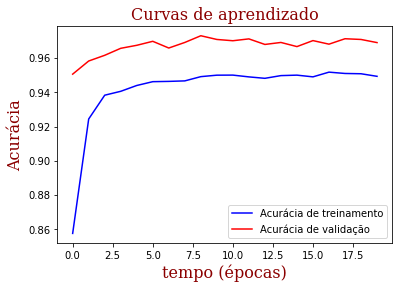

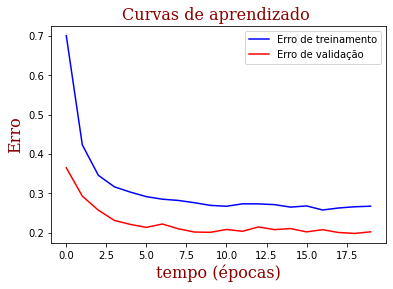

313/313 [==============================] - 0s 1ms/step - loss: 0.2010 - accuracy: 0.9690
Acurácia do teste: 0.968999981880188


In [ ]:
# arquivo: mnist_10_adam_reg_BN_8layers_dropout.py
# Adaptação dos códigos do livro "Deep Learning with TensorFlow2
# and Keras: Regression, Convnets, GANs RNNs, NLP and more with
# TensorFlow2 and the Keras API, de Antonio Gulli, Amita Kapoor 
# e Sujit Pal, 2a ed., Packt. 
# otimizador = Adam
# regularização com BATCH NORMALIZATION
# código para TensorFlow 2.1.0 Spyder - Anaconda
# autor: Alexandre B. de Lima (ABL)

import tensorflow as tf
#import numpy as np
from tensorflow import keras
from keras import regularizers
print("Tensorflow version " + tf.__version__)

# #%% define célula

# Parâmetros da rede e de treinamento
epocas = 20    # define a duração do treinamento
lote_tam = 64  # número de amostras que alimentarão a rede em uma dada época
               # de treinamento (em inglês, lote = batch)
verbose = 1
n_classes = 10 # número de saídas = número de dígitos
n_oculta = 128 
val_split = 0.2 # a fração do número de amostras de treinamento reservadas para
                # validação => 48.000 amostras para treino + 12.000 amostras para 
                # validação = 60.000 exemplos do conjunto de treinamento MNIST     
dropout = 0.3   # técnica de regularização
                # A idéia por trás dessa melhoria é que o descarte aleatório força a 
                # rede a aprender padrões redundantes que são úteis para uma melhor generalização

#%

# carrega a base de dados MNIST
#mnist = keras.datasets.mnist
from keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()


reformat = 784 # é a dimensão do espaço de "features"
               # ou seja, a camada de entrada possui 784 "input units"
               # Uma entrada é um vetor coluna 784 x 1
 
X_train = X_train.reshape(60000, reformat) 
X_test = X_test.reshape(10000, reformat) 

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalização em [0,1]
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'amostras de treinamento')
print(X_test.shape[0], 'amostras de teste')

# Representação "one-hot" dos rótulos (labels) de treinamento e teste
Y_train = tf.keras.utils.to_categorical(Y_train, n_classes)
Y_test = tf.keras.utils.to_categorical(Y_test, n_classes)

#%
# construção do modelo
# A camada de saída é composta por 10 neurônios com função de ativação "softmax", que é uma 
# generalização da função sigmóide ou logística. 

# BATCH NORMALIZATION (BN)
# Treinar redes neurais profundas é difícil. E fazê-las convergir em uma quantidade razoável de tempo pode ser complicado.
# A normalização de lotes (BN) é uma técnica popular e eficaz que acelera consistentemente a convergência de redes profundas. 
# Juntamente com os blocos residuais (não foi implementado neste código), o BN tornou possível para os profissionais 
# treinar rotineiramente redes com mais de 100 camadas.

model = tf.keras.models.Sequential()
model.add(keras.layers.Dense(n_oculta, input_shape=(reformat,), kernel_regularizer=regularizers.l2(0.001),
                             name='dense_layer1', activation='relu'))
model.add(keras.layers.Dropout(dropout))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(n_oculta, input_shape=(reformat,), kernel_regularizer=regularizers.l2(0.001),
                             name='dense_layer2', activation='relu'))
model.add(keras.layers.Dropout(dropout))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(n_classes, input_shape=(reformat,), name='dense_layer3', activation='softmax'))

# sumário do modelo
model.summary()

#%
# compilando o modelo
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
# RMSProp tende a convergir mais rápido que o SGD, vide:
# https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a

#%
# treinamento do modelo no TensorFlow 2
treino = model.fit(X_train, Y_train, batch_size=lote_tam, epochs=epocas, verbose=verbose, validation_split=val_split)
# model.fit retorna o objeto "treino", que é do tipo "History".  

treino_dic = treino.history 
# "treino.history" retorna um contêiner de dicionário (uma generalização do conceito de lista): tipo "dict" 
# Um dicionário contém pares de (chave, valor)
treino_dic.keys()
# chaves no tf 2.1.0: ['loss', 'accuracy', 'val_loss', 'val_accuracy']

import matplotlib.pyplot as plt

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

acc = treino.history['accuracy']
val_acc = treino.history['val_accuracy']
loss = treino.history['loss']
val_loss = treino.history['val_loss']

epochs = range(len(acc))

plt.clf()

plt.plot(epochs, acc, 'b', label='Acurácia de treinamento')
plt.plot(epochs, val_acc, 'r', label='Acurácia de validação')
plt.title('Curvas de aprendizado', fontdict=font)
plt.xlabel('tempo (épocas)', fontdict=font)
plt.ylabel('Acurácia', fontdict=font)
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Erro de treinamento')
plt.plot(epochs, val_loss, 'r', label='Erro de validação')
plt.title('Curvas de aprendizado ', fontdict=font)
plt.xlabel('tempo (épocas)', fontdict=font)
plt.ylabel('Erro', fontdict=font)
plt.legend()

plt.show()

# O gráfico de custo de treinamento e validação sugere que o "overfitting" ocorre após 9 épocas
# ATENÇÃO: os "scores" de validação podem variar em função da partição do conjunto de treinamento que
# você escolheu usar para validação e de treinamento: os "scores" de validação podem ter uma alta vari6ancia 
# em relação ao "split" de validação.

#%
# avaliação do modelo
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Acurácia do teste:', test_acc)
# acurácio de teste: 97,15% 

#%
# previsões
predictions = model.predict(X_test)
